In [1]:
# import package
# installed via pip
from emtracks.particle import * # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
from emtracks.interpolations import *
import matplotlib.animation as animation
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')
import os

from joblib import Parallel, delayed
import multiprocessing
from tqdm.notebook import tqdm


rad13plotdir = '/home/shared_data/mao10,mao13_analysis/plots/mao13(0.90,1.10TS)rad/'
reg13plotdir = '/home/shared_data/mao10,mao13_analysis/plots/mao13(0.90,1.10TS)/'
mao13datadir = '/home/shared_data/mao10,mao13_analysis/data/mao13contourplots4/'

In [2]:
files = sorted(os.listdir(mao13datadir)) #all your files

In [3]:
#check initconds match with title theta/phi
asdf = []
for file in files:
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
    theta = float(file.split('_')[1])
    phi = float(file.split('_')[2])
    thetainitcond = round(e_solvernom.init_conds.theta0, 3)
    phiinitcond = round(e_solvernom.init_conds.phi0, 3)
    asdf.append([(theta-thetainitcond), (phi-phiinitcond)])

asdf = np.array(asdf)
    
asdf
asdf.mean(), asdf.std()

(0.0, 0.0)

In [4]:
asdf.mean(), asdf.std(), asdf.min(), asdf.max()

(0.0, 0.0, 0.0, 0.0)

In [6]:
files[500]

'0.90_2.117_0.000_0.054_.pkl'

In [5]:
e_solvernom = trajectory_solver.from_pickle(mao13datadir+files[500])
e_solvernom.dataframe
e_solvernom.init_conds.theta0

2.1166326530612247

In [7]:
files[0].split('_')

['0.90', '2.085', '0.000', '0.054', '.pkl']

In [8]:
bounce = True
files_new = []

for file in files:
    if file[0:5] != '1.000':
        files_new.append(file)

files = files_new

In [10]:
len(files)

52500

In [11]:
info = []
deleted = []
for file in files:
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
    field = file.split('_')[0]
    phi = e_solvernom.init_conds.phi0
    theta = e_solvernom.init_conds.theta0
    
    if e_solvernom.dataframe.z.max() < 7.00:
        bounce = 0
    else:
        bounce = 1
        
    info.append([field, theta, phi, bounce])
    
df = pd.DataFrame(info, columns = ['field', 'theta', 'phi', 'bounce'])  

In [26]:
info

[['0.90', 2.085, 0.0, 1],
 ['0.90', 2.085, 0.1282282715750936, 1],
 ['0.90', 2.085, 0.2564565431501872, 1],
 ['0.90', 2.085, 0.38468481472528077, 1],
 ['0.90', 2.085, 0.5129130863003744, 1],
 ['0.90', 2.085, 0.6411413578754679, 1],
 ['0.90', 2.085, 0.7693696294505615, 1],
 ['0.90', 2.085, 0.8975979010256552, 1],
 ['0.90', 2.085, 1.0258261726007487, 1],
 ['0.90', 2.085, 1.1540544441758422, 1],
 ['0.90', 2.085, 1.2822827157509358, 1],
 ['0.90', 2.085, 1.4105109873260295, 1],
 ['0.90', 2.085, 1.538739258901123, 1],
 ['0.90', 2.085, 1.6669675304762166, 1],
 ['0.90', 2.085, 1.7951958020513104, 1],
 ['0.90', 2.085, 1.9234240736264039, 1],
 ['0.90', 2.085, 2.0516523452014974, 1],
 ['0.90', 2.085, 2.179880616776591, 1],
 ['0.90', 2.085, 2.3081088883516845, 1],
 ['0.90', 2.085, 2.436337159926778, 1],
 ['0.90', 2.085, 2.5645654315018716, 1],
 ['0.90', 2.085, 2.6927937030769655, 1],
 ['0.90', 2.085, 2.821021974652059, 1],
 ['0.90', 2.085, 2.9492502462271526, 1],
 ['0.90', 2.085, 3.077478517802246

In [12]:
np.array(info).shape

(52500, 4)

In [13]:
df['field'].unique()

array(['0.90', '0.91', '0.92', '0.93', '0.94', '0.95', '0.96', '0.97',
       '0.98', '0.99', '1.00', '1.01', '1.02', '1.03', '1.04', '1.05',
       '1.06', '1.07', '1.08', '1.09', '1.10'], dtype=object)

In [14]:
df['bounce'].unique()

array([1, 0])

In [15]:
dfnew9 = df[df['field']=='0.90']
dfnew1 = df[df['field']=='1.00'] #want this bounce 
dfnew11 = df[df['field']=='1.10']# want this not bounce

In [34]:
mask1 = (dfnew1.bounce == 1).values
mask2 = (dfnew11.bounce == 0).values

(mask1 & mask2).sum()

3

In [35]:
dfnow = dfnew1[mask1 & mask2]

In [38]:
dfnow

,field,theta,phi,bounce
26890,1.00,2.202041,5.129131,1
26942,1.00,2.205204,5.385587,1
26943,1.00,2.205204,5.513816,1


In [36]:
dfnew1[mask1 & mask2]

,field,theta,phi,bounce
26890,1.00,2.202041,5.129131,1
26942,1.00,2.205204,5.385587,1
26943,1.00,2.205204,5.513816,1


In [37]:
dfnew11[mask1 & mask2]

,field,theta,phi,bounce
51890,1.10,2.202041,5.129131,0
51942,1.10,2.205204,5.385587,0
51943,1.10,2.205204,5.513816,0


In [18]:
def getDSfield(file):
    return file.split('_')[1].split('x')[0]
def getPSfield(file):
    return file.split('_')[2].split('x')[0]

def getfiles(files, field, thetas, phis):
    fieldrounded = round(field, 3)
    thetasrounded = [round(num, 3) for num in thetas]
    phisrounded = [round(num, 3) for num in phis]
    
    filedata = []
    for file in files:
        if np.isclose(float(file.split('_')[0]), field, 1e-5):
            if float(getDSfield(file)) in thetasrounded:
                if float(getPSfield(file)) in phisrounded:
                    filedata.append(file)
    
    return filedata

filedata = getfiles(files, 1.00, dfnow['theta'], dfnow['phi'])
filedata2 = getfiles(files, 1.10, dfnow['theta'], dfnow['phi'])

In [54]:
np.array(filedata)[[0,4,5]]

array(['1.00_2.202_5.129_0.054_.pkl', '1.00_2.205_5.386_0.054_.pkl',
       '1.00_2.205_5.514_0.054_.pkl'], dtype='<U27')

In [58]:
e_solvernom.init_conds.x0

0.054094482

In [59]:
x0 = 0.054094482
field = 1.00
theta = 2.202041
phi = 5.129131
f'{field:0.2f}_{theta:0.3f}_{phi:0.3f}_{x0:0.3f}_.pkl'

'1.00_2.202_5.129_0.054_.pkl'

In [60]:
x0 = 0.054094482
for row in dfnow.itertuples():
    print(f'{row.field}_{row.theta:0.3f}_{row.phi:0.3f}_{x0:0.3f}_.pkl')

1.00_2.202_5.129_0.054_.pkl
1.00_2.205_5.386_0.054_.pkl
1.00_2.205_5.514_0.054_.pkl


In [51]:
filedata[0,4,5]

TypeError: list indices must be integers or slices, not tuple

In [47]:
filedata2

['1.10_2.202_5.129_0.054_.pkl',
 '1.10_2.202_5.386_0.054_.pkl',
 '1.10_2.202_5.514_0.054_.pkl',
 '1.10_2.205_5.129_0.054_.pkl',
 '1.10_2.205_5.386_0.054_.pkl',
 '1.10_2.205_5.514_0.054_.pkl']

In [39]:
tempfiles = filedata[0:3]
tempfiles2 = filedata2[0:3]

In [45]:
tempfiles

['1.00_2.202_5.129_0.054_.pkl',
 '1.00_2.202_5.386_0.054_.pkl',
 '1.00_2.202_5.514_0.054_.pkl']

In [40]:
tempfiles

['1.00_2.202_5.129_0.054_.pkl',
 '1.00_2.202_5.386_0.054_.pkl',
 '1.00_2.202_5.514_0.054_.pkl']

In [41]:
tempfiles2

['1.10_2.202_5.129_0.054_.pkl',
 '1.10_2.202_5.386_0.054_.pkl',
 '1.10_2.202_5.514_0.054_.pkl']

In [48]:
dfnow[['phi','theta']]

,phi,theta
26890,5.129131,2.202041
26942,5.385587,2.205204
26943,5.513816,2.205204


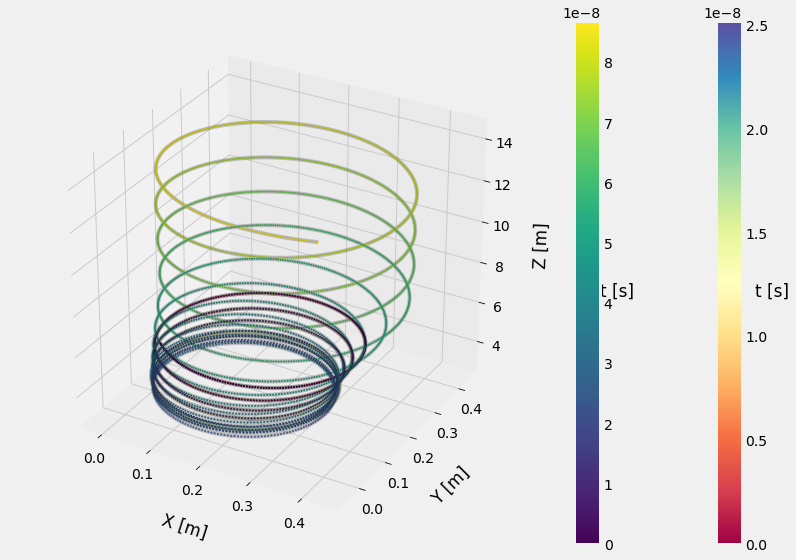

In [32]:
i = 2
e_solvernom = trajectory_solver.from_pickle(mao13datadir+tempfiles[i])
e_solvernom2 = trajectory_solver.from_pickle(mao13datadir+tempfiles2[i])

#e_solvernom.dataframe = e_solvernom.dataframe
#e_solvernom2.dataframe = e_solvernom2.dataframe

fig, ax = e_solvernom.plot3d(cmap = 'Spectral')
fig, ax = e_solvernom2.plot3d(fig = fig, ax = ax)

In [33]:
e_solvernom.dataframe.z.max(), e_solvernom2.dataframe.z.max()

(5.988900879, 14.136590962176108)

In [17]:
zees = {}
for field in df['field'].unique():
    df2 = df[df['field']==field]
    dfbounce = df2[(df2['bounce']==1) & (df2['field']==field)]

    bounce = [] 
    for i in range(0, len(dfbounce['theta'].values), 1):
        bounce.append([dfbounce['theta'].values[i], dfbounce['phi'].values[i]]) #all pairs of [theta, phi] that bounce

    thetas = np.array(df2['theta'].unique())
    phis = np.array(df2['phi'].unique())
    z = np.zeros((len(phis), len(thetas)))

    for phi in range(0, len(phis), 1):
        for theta in range(0, len(thetas), 1):
            if [thetas[theta], phis[phi]] in bounce:
                z[phi][theta] = 1 
                
    zees.update({f'{field}':z})

In [18]:
zees

{'0.90': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 '0.91': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 '0.92': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 '0.93': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 

Text(0.5, 0.98, 'Particles that Bounce in Different Distorted TS Field Scenarios')

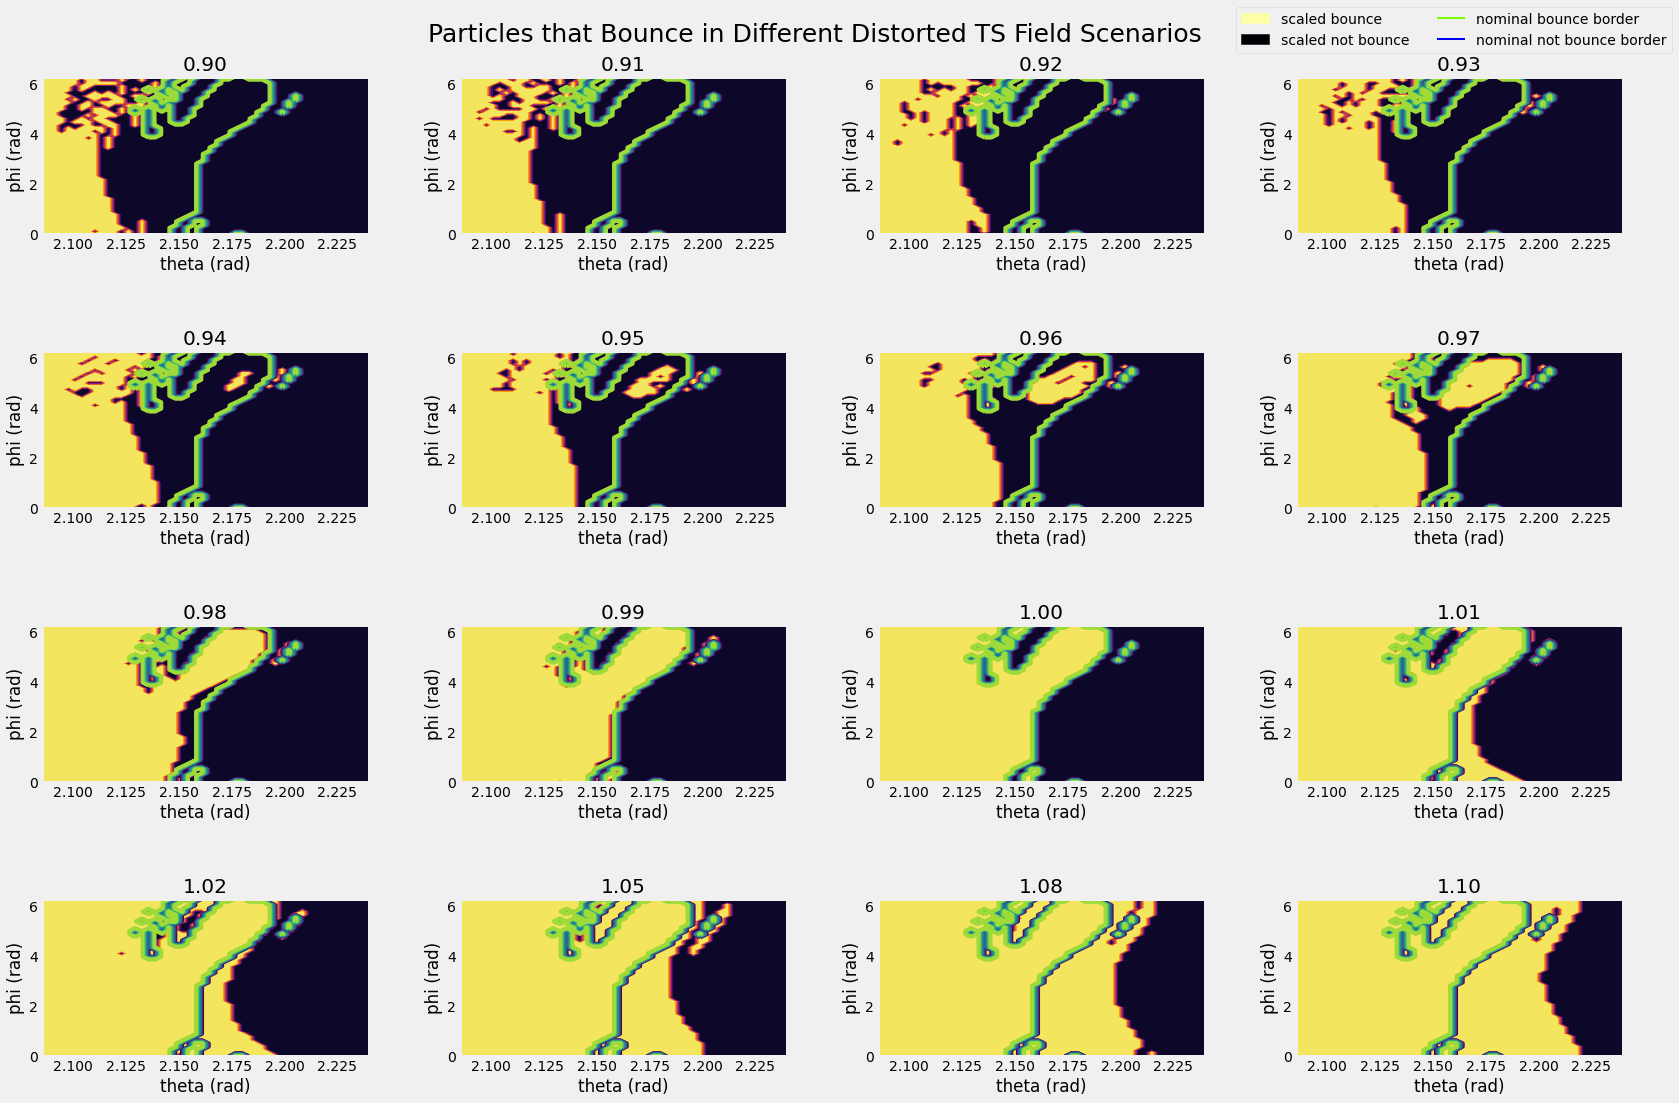

In [19]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
fig = plt.figure()
ax1 = plt.subplot2grid((4,4), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((4,4), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((4,4), (0,2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((4,4), (0,3), rowspan=1, colspan=1)
ax5 = plt.subplot2grid((4,4), (1,0), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((4,4), (1,1), rowspan=1, colspan=1)
ax7 = plt.subplot2grid((4,4), (1,2), rowspan=1, colspan=1)
ax8 = plt.subplot2grid((4,4), (1,3), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((4,4), (2,0), rowspan=1, colspan=1)
ax10 = plt.subplot2grid((4,4), (2,1), rowspan=1, colspan=1)
ax11 = plt.subplot2grid((4,4), (2,2), rowspan=1, colspan=1)
ax12 = plt.subplot2grid((4,4), (2,3), rowspan=1, colspan=1)
ax13 = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=1)
ax14 = plt.subplot2grid((4,4), (3,1), rowspan=1, colspan=1)
ax15 = plt.subplot2grid((4,4), (3,2), rowspan=1, colspan=1)
ax16 = plt.subplot2grid((4,4), (3,3), rowspan=1, colspan=1)


ax1.contourf(thetas, phis, zees['0.90'], cmap = 'inferno')
ax1.set_title(f'0.90')
ax1.set_xlabel(f'theta (rad)')
ax1.set_ylabel(f'phi (rad)')
ax1.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax2.contourf(thetas, phis, zees['0.91'], cmap = 'inferno')
ax2.set_title(f'0.91')
ax2.set_xlabel(f'theta (rad)')
ax2.set_ylabel(f'phi (rad)')
ax2.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax3.contourf(thetas, phis, zees['0.92'], cmap = 'inferno')
ax3.set_title(f'0.92')
ax3.set_xlabel(f'theta (rad)')
ax3.set_ylabel(f'phi (rad)')
ax3.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax4.contourf(thetas, phis, zees['0.93'], cmap = 'inferno')
ax4.set_title(f'0.93')
ax4.set_xlabel(f'theta (rad)')
ax4.set_ylabel(f'phi (rad)')
ax4.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax5.contourf(thetas, phis, zees['0.94'], cmap = 'inferno')
ax5.set_title(f'0.94')
ax5.set_xlabel(f'theta (rad)')
ax5.set_ylabel(f'phi (rad)')
ax5.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax6.contourf(thetas, phis, zees['0.95'], cmap = 'inferno')
ax6.set_title(f'0.95')
ax6.set_xlabel(f'theta (rad)')
ax6.set_ylabel(f'phi (rad)')
ax6.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax7.contourf(thetas, phis, zees['0.96'], cmap = 'inferno')
ax7.set_title(f'0.96')
ax7.set_xlabel(f'theta (rad)')
ax7.set_ylabel(f'phi (rad)')
ax7.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax8.contourf(thetas, phis, zees['0.97'], cmap = 'inferno')
ax8.set_title(f'0.97')
ax8.set_xlabel(f'theta (rad)')
ax8.set_ylabel(f'phi (rad)')
ax8.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax9.contourf(thetas, phis, zees['0.98'], cmap = 'inferno')
ax9.set_title(f'0.98')
ax9.set_xlabel(f'theta (rad)')
ax9.set_ylabel(f'phi (rad)')
ax9.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax10.contourf(thetas, phis, zees['0.99'], cmap = 'inferno')
ax10.set_title(f'0.99')
ax10.set_xlabel(f'theta (rad)')
ax10.set_ylabel(f'phi (rad)')
ax10.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax11.contourf(thetas, phis, zees['1.00'], cmap = 'inferno')
ax11.set_title(f'1.00')
ax11.set_xlabel(f'theta (rad)')
ax11.set_ylabel(f'phi (rad)')
ax11.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax12.contourf(thetas, phis, zees['1.01'], cmap = 'inferno')
ax12.set_title(f'1.01')
ax12.set_xlabel(f'theta (rad)')
ax12.set_ylabel(f'phi (rad)')
ax12.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax13.contourf(thetas, phis, zees['1.02'], cmap = 'inferno')
ax13.set_title(f'1.02')
ax13.set_xlabel(f'theta (rad)')
ax13.set_ylabel(f'phi (rad)')
ax13.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax14.contourf(thetas, phis, zees['1.05'], cmap = 'inferno')
ax14.set_title(f'1.05')
ax14.set_xlabel(f'theta (rad)')
ax14.set_ylabel(f'phi (rad)')
ax14.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax15.contourf(thetas, phis, zees['1.08'], cmap = 'inferno')
ax15.set_title(f'1.08')
ax15.set_xlabel(f'theta (rad)')
ax15.set_ylabel(f'phi (rad)')
ax15.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

ax16.contourf(thetas, phis, zees['1.10'], cmap = 'inferno')
ax16.set_title(f'1.10')
ax16.set_xlabel(f'theta (rad)')
ax16.set_ylabel(f'phi (rad)')
ax16.contour(thetas, phis, zees['1.00'], cmap = 'viridis')

cmap = plt.cm.get_cmap('inferno')
rgba = cmap(0.0)
rgba2 = cmap(1.0)
bounces = mpatches.Patch(color=rgba, label = 'scaled not bounce')
notbounces = mpatches.Patch(color=rgba2, label = 'scaled bounce')
 
nomcmap = plt.cm.get_cmap('viridis')
rgba3 = nomcmap(1.0)
rgba4 = nomcmap(0.0)
overlay = Line2D([0], [0], color='lawngreen', lw = 2, label = 'nominal bounce border')
overlay2 = Line2D([0], [0], color='blue', lw = 2, label = 'nominal not bounce border')
fig.legend(handles = [notbounces, bounces, overlay, overlay2], ncol = 2)



fig.tight_layout(pad = 4.0)
fig.suptitle('Particles that Bounce in Different Distorted TS Field Scenarios', fontsize = '25')

In [20]:
zeees = {}
for field in df['field'].unique():
    thetadif = (thetas[-1] - thetas[0])/(len(thetas))
    phidif = (phis[-1] - phis[0])/(len(phis))
    scaledthetas = []
    scaledphis = []
    for theta in thetas:
        scaledthetas.append(theta-thetadif)
    scaledthetas.append(thetas[-1] + thetadif)

    for phi in phis:
        scaledphis.append(phi-phidif)
    scaledphis.append(phis[-1] + phidif)
    
    zeees.update({f'{field}': [scaledthetas, scaledphis]})

Text(0.5, 0.98, 'Particles that Bounce in Different Distorted TS Field Scenarios')

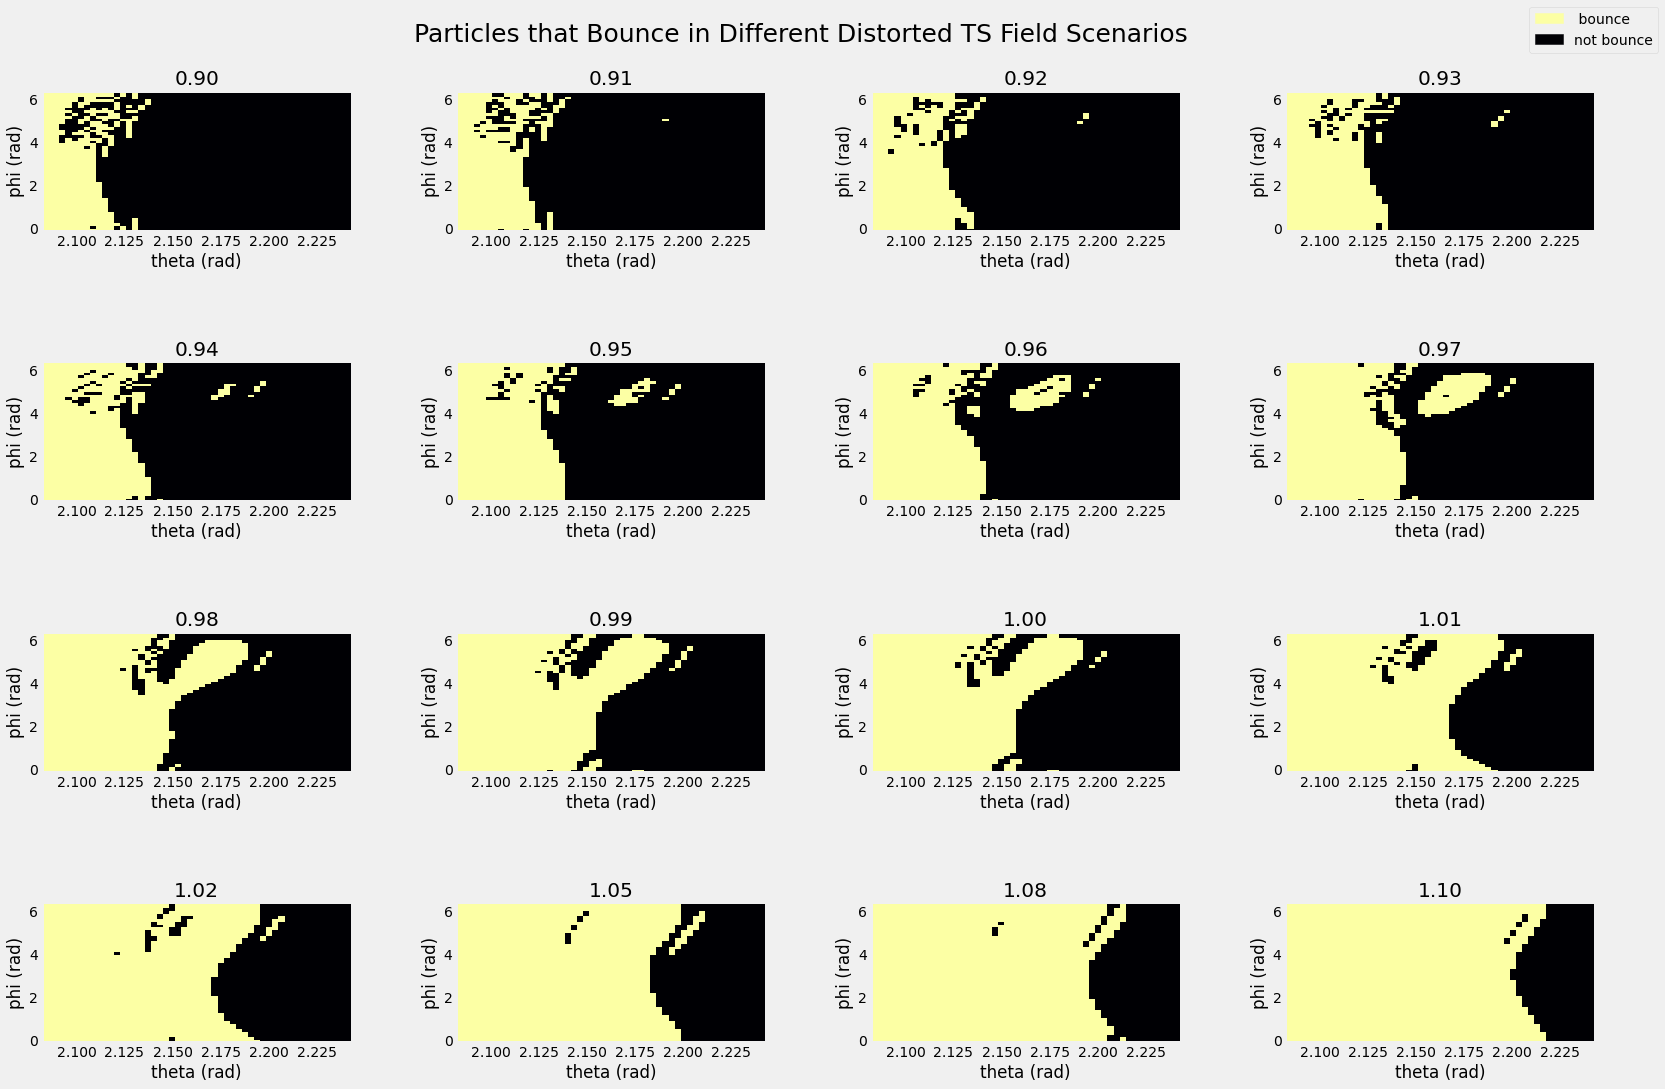

In [21]:
fig = plt.figure()
ax1 = plt.subplot2grid((4,4), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((4,4), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((4,4), (0,2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((4,4), (0,3), rowspan=1, colspan=1)
ax5 = plt.subplot2grid((4,4), (1,0), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((4,4), (1,1), rowspan=1, colspan=1)
ax7 = plt.subplot2grid((4,4), (1,2), rowspan=1, colspan=1)
ax8 = plt.subplot2grid((4,4), (1,3), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((4,4), (2,0), rowspan=1, colspan=1)
ax10 = plt.subplot2grid((4,4), (2,1), rowspan=1, colspan=1)
ax11 = plt.subplot2grid((4,4), (2,2), rowspan=1, colspan=1)
ax12 = plt.subplot2grid((4,4), (2,3), rowspan=1, colspan=1)
ax13 = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=1)
ax14 = plt.subplot2grid((4,4), (3,1), rowspan=1, colspan=1)
ax15 = plt.subplot2grid((4,4), (3,2), rowspan=1, colspan=1)
ax16 = plt.subplot2grid((4,4), (3,3), rowspan=1, colspan=1)

ax1.pcolormesh(zeees['0.90'][0], zeees['0.90'][1], zees['0.90'], cmap = 'inferno')
ax1.set_title(f'0.90')
ax1.set_xlabel(f'theta (rad)')
ax1.set_ylabel(f'phi (rad)')

ax2.pcolormesh(zeees['0.91'][0], zeees['0.91'][1], zees['0.91'], cmap = 'inferno')
ax2.set_title(f'0.91')
ax2.set_xlabel(f'theta (rad)')
ax2.set_ylabel(f'phi (rad)')

ax3.pcolormesh(zeees['0.92'][0], zeees['0.92'][1], zees['0.92'], cmap = 'inferno')
ax3.set_title(f'0.92')
ax3.set_xlabel(f'theta (rad)')
ax3.set_ylabel(f'phi (rad)')

ax4.pcolormesh(zeees['0.93'][0], zeees['0.93'][1], zees['0.93'], cmap = 'inferno')
ax4.set_title(f'0.93')
ax4.set_xlabel(f'theta (rad)')
ax4.set_ylabel(f'phi (rad)')

ax5.pcolormesh(zeees['0.94'][0], zeees['0.94'][1], zees['0.94'], cmap = 'inferno')
ax5.set_title(f'0.94')
ax5.set_xlabel(f'theta (rad)')
ax5.set_ylabel(f'phi (rad)')

ax6.pcolormesh(zeees['0.95'][0], zeees['0.95'][1], zees['0.95'], cmap = 'inferno')
ax6.set_title(f'0.95')
ax6.set_xlabel(f'theta (rad)')
ax6.set_ylabel(f'phi (rad)')

ax7.pcolormesh(zeees['0.96'][0], zeees['0.96'][1], zees['0.96'], cmap = 'inferno')
ax7.set_title(f'0.96')
ax7.set_xlabel(f'theta (rad)')
ax7.set_ylabel(f'phi (rad)')

ax8.pcolormesh(zeees['0.97'][0], zeees['0.97'][1], zees['0.97'], cmap = 'inferno')
ax8.set_title(f'0.97')
ax8.set_xlabel(f'theta (rad)')
ax8.set_ylabel(f'phi (rad)')

ax9.pcolormesh(zeees['0.98'][0], zeees['0.98'][1], zees['0.98'], cmap = 'inferno')
ax9.set_title(f'0.98')
ax9.set_xlabel(f'theta (rad)')
ax9.set_ylabel(f'phi (rad)')

ax10.pcolormesh(zeees['0.99'][0], zeees['0.99'][1], zees['0.99'], cmap = 'inferno')
ax10.set_title(f'0.99')
ax10.set_xlabel(f'theta (rad)')
ax10.set_ylabel(f'phi (rad)')

ax11.pcolormesh(zeees['1.00'][0], zeees['1.00'][1], zees['1.00'], cmap = 'inferno')
ax11.set_title(f'1.00')
ax11.set_xlabel(f'theta (rad)')
ax11.set_ylabel(f'phi (rad)')

ax12.pcolormesh(zeees['1.01'][0], zeees['1.01'][1], zees['1.01'], cmap = 'inferno')
ax12.set_title(f'1.01')
ax12.set_xlabel(f'theta (rad)')
ax12.set_ylabel(f'phi (rad)')

ax13.pcolormesh(zeees['1.02'][0], zeees['1.02'][1], zees['1.02'], cmap = 'inferno')
ax13.set_title(f'1.02')
ax13.set_xlabel(f'theta (rad)')
ax13.set_ylabel(f'phi (rad)')

ax14.pcolormesh(zeees['1.05'][0], zeees['1.05'][1], zees['1.05'], cmap = 'inferno')
ax14.set_title(f'1.05')
ax14.set_xlabel(f'theta (rad)')
ax14.set_ylabel(f'phi (rad)')

ax15.pcolormesh(zeees['1.08'][0], zeees['1.08'][1], zees['1.08'], cmap = 'inferno')
ax15.set_title(f'1.08')
ax15.set_xlabel(f'theta (rad)')
ax15.set_ylabel(f'phi (rad)')

ax16.pcolormesh(zeees['1.10'][0], zeees['1.10'][1], zees['1.10'], cmap = 'inferno')
ax16.set_title(f'1.10')
ax16.set_xlabel(f'theta (rad)')
ax16.set_ylabel(f'phi (rad)')


cmap = plt.cm.get_cmap('inferno')
rgba = cmap(0.0)
rgba2 = cmap(1.0)
bounces = mpatches.Patch(color=rgba, label = 'not bounce')
notbounces = mpatches.Patch(color=rgba2, label = ' bounce')
fig.legend(handles = [notbounces, bounces])


fig.tight_layout(pad = 5.0)
fig.suptitle('Particles that Bounce in Different Distorted TS Field Scenarios', fontsize = '25')
